# 4. Preprocessament de les imatges - patch extraction

### Input: Arxiu .csv amb les rutes i característiques de les mamografies unificades. 

### Output: Arrays de numpy de les imatges i etiquetes corresponents per a l'entrenament, validació i test. Arxius csv corresponents amb els index de les imatges.

**En l'apartat anterior hem vist les dificultats del model per classificar correctament entre lesions benignes i malignes, probablement degut al fet que en molts casos les lesions ocupen una proporció molt petita del total de la mamografia. També influencia la varietat de lesions de diferents mides que hi pot haver i la diversitat en l'anatomia mamària de la població**

En aquest apartat hem creat un model extractor de 'parches'. Ens hem basat (DE MOMENT) en el dataset DDSM, que conté una imatge binària associada per cada lesió.

El procediment seguit és el següent:

- Carregar imatge binaria
- Buscar el rectangle delimitador de la lesió.
- Extreure un rectangle de la mida de 500 pixels de cada lesió (és la mida màxima de les lesions per tal que no quedi cap lesió tallada)
- Extreure un rectangle de la mateixa mida de les mamografies normals (he aplicat un llindar píxels blancs que és l'equivalent al 25-75% de les imatges amb lesions,  per tal que siguin equiparables)
- Preprocessar les imatges de manera semblant a les mamografies senceres i redimensionar a 224x224
- Representar exemples i guardar arrays de numpy per entrenar


## Carreguem les llibreries

In [1]:
from keras.utils import image_dataset_from_directory

from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input, 
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, AveragePooling2D,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Lambda)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from keras.optimizers import (Adam, RMSprop)
from keras import Sequential, Model

import tensorflow as tf

from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import random
import cv2


In [2]:
# Importem Tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necessitarem GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

#Keras version is 3.0.5
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.16.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  3.1.1


In [3]:
df = pd.read_csv('LabelsPaths.csv')

**En primer lloc represntarem les imatges amb la lesió corresponent per comprendre millor el procés**

1.0
1
172 156


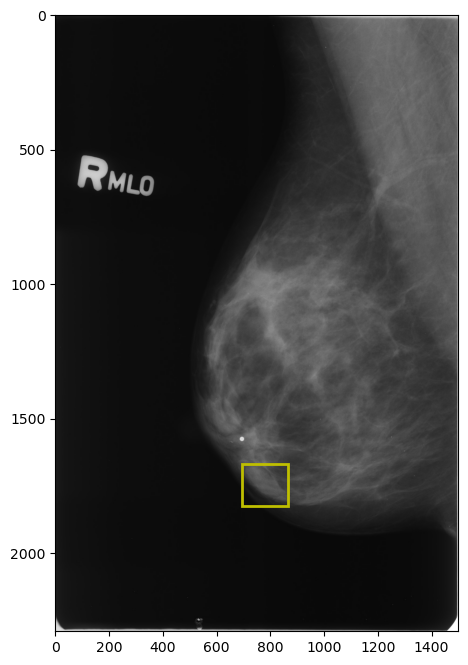

1.0
2
388 404


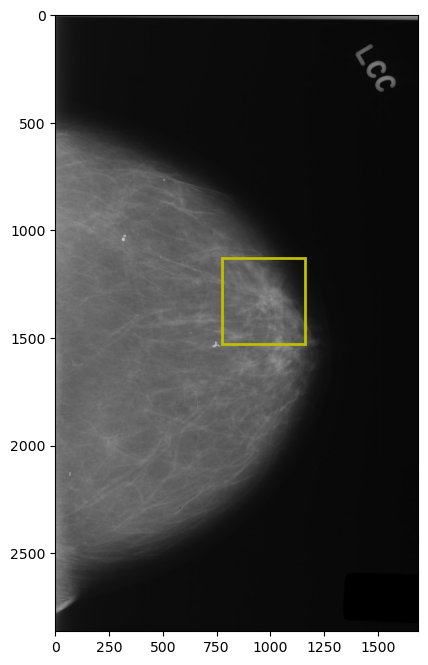

1.0
1
164 164


1.0
2
348 332


0.0
1
148 132


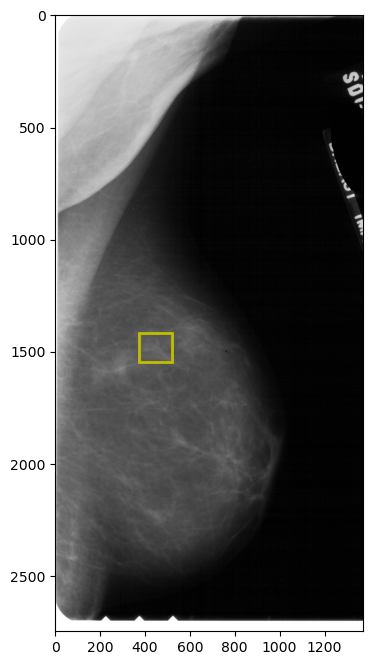

1.0
2
332 276


In [4]:
sampled_images = df[df['Database'] == 'DDSM'].sample(n=15)

for index, row in sampled_images.iterrows():
    image_path = row['Path']
    img = cv2.imread(image_path)

    mask_path = image_path.replace('.jpg', '_Mask.jpg')

    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        mask_dilated = cv2.dilate(mask, None, iterations=2)

        contours, _ = cv2.findContours(mask_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        x, y, w, h = cv2.boundingRect(contours[0])
     
        plt.figure(figsize=(8, 8))
        
        plt.imshow(img)
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='y', linewidth=2)
        plt.gca().add_patch(rect)
        print(row['Mass'])
        print(row['Label'])
        print(w, h)
        
        
        plt.show()


# 4.1. Preprocessament de fragments de la base de dades DDSM

### 4.1.1. Funcions per extreure els patch 

In [5]:
def extract_patch_from_image(image_path, patch_size):
    """
    Extreu un patch del tamany patch_size que conté corresponent a la màscara binària.

    Args:
    - image_path: Ruta de la imatge.
    - patch_size: Mida del patch en píxeles.

    Returns:
    - Patch de la lesió mamogràfica o None si la imatge no es troba.
    """
    # Construim la ruta a la imatge de la màscara binaria
    mask_path = image_path.replace('.jpg', '_Mask.jpg')

    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Hem de dilatar el contorn perquè en alguns casos no es trobava el contorn sencer
        mask_dilated = cv2.dilate(mask, None, iterations=2)

        # Troba el contorn de la màscara
        contours, _ = cv2.findContours(mask_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            return None

        # Busquem el rectangle delimitador dels contorns
        x, y, w, h = cv2.boundingRect(contours[0])

        # Busquem les coordenades del patch, la primera opció és que estigui cetrat
        center_x = x + w // 2
        center_y = y + h // 2
        patch_x = max(0, center_x - patch_size[0] // 2)
        patch_y = max(0, center_y - patch_size[1] // 2)
        patch_x_end = min(mask.shape[1], patch_x + patch_size[0])
        patch_y_end = min(mask.shape[0], patch_y + patch_size[1])

        # Si el patch surt de la imatge, el resituem, mantinguent la mida del patch

        if patch_x_end - patch_x < patch_size[0]:
            patch_x = max(0, patch_x_end - patch_size[0])
        if patch_y_end - patch_y < patch_size[1]:
            patch_y = max(0, patch_y_end - patch_size[1])

        # patch_mask = mask[patch_y:patch_y_end, patch_x:patch_x_end]
        
        original_image_path = image_path
        original_image = cv2.imread(original_image_path)

        patch_image = original_image[patch_y:patch_y_end, patch_x:patch_x_end]

        return patch_image
    else:
        return None

def trim_image(image, margin=20):
    """
    Retalla una imatge en els marges especificats.

    Args:
    - image (array): Imatge d'entrada.
    - margin (int): Mida del marge a retallar de la imatge. El valor per defecte és 20.

    Returns:
    - array: Imatge retallada.
    """
    height, width = image.shape[:2]
    trimmed_image = image[margin:height-margin, margin:width-margin]

    return trimmed_image
    
def preprocess_image(img_path, threshold_value=35):
    """
    Realitza el pre-processament de la imatge especificada.

    Args:
    - img_path (str): Ruta de la imatge a pre-processar.
    - threshold_value (int): Valor de llindar per a la binarització. El valor per defecte és 30.

    Returns:
    - tuple: Una tupla que conté tres elements:
        * result (array): Imatge pre-processada amb la màscara aplicada.
        * crop (array): Regió retallada de la imatge original.
        * mask (array): Màscara binària que delimita la regió d'interès.
    """
    try:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Imatge no trobada: {img_path}")
            return None, None
            
        img2 = trim_image(img)
        gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        thresh1 = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)[1]
        thresh1 = 255 - thresh1
        count_cols = np.count_nonzero(thresh1, axis=0)
        first_x = np.where(count_cols>0)[0][0]
        last_x = np.where(count_cols>0)[0][-1]
        count_rows = np.count_nonzero(thresh1, axis=1)
        first_y = np.where(count_rows>0)[0][0]
        last_y = np.where(count_rows>0)[0][-1]
        crop = img[first_y:last_y+1, first_x:last_x+1]
        thresh2 = thresh1[first_y:last_y+1, first_x:last_x+1]
        thresh2 = 255 - thresh2
        contours = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        big_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(thresh2, dtype=np.uint8)
        cv2.drawContours(mask, [big_contour], 0, 255, -1)
        result = crop.copy()
        result[mask==0] = (0,0,0)
        return result, crop, mask
            
    except Exception as e:
        print(f"Error: {e}")
        return None

def get_valid_patch(result, patch_size, max_attempts=15):
    """
    Obté un patch vàlid de la imatge resultant.

    Aquesta funció genera de forma aleatòria un patch dins de la imatge
    resultant, comprovant si la mitjana dels valors de píxel del patch supera
    un llindar específic. Si es compleix aquesta condició, el patch és vàlid
    i es retorna. En cas contrari, es repeteix el procés fins a un nombre màxim
    d'intents.

    Args:
    - result (array): Imatge resultant.
    - patch_size (tuple): Mida del patch en forma de tupla (ample, alçada).
    - max_attempts (int): Nombre màxim d'intents per trobar un patch vàlid.
                          El valor per defecte és 10.

    Returns:
    - array: Patch vàlid de la imatge resultant, o None si no s'ha pogut
             trobar cap patch vàlid després de diversos intents.
    """
    attempts = 0
    while attempts < max_attempts:
        if patch_size[0] > result.shape[1] or patch_size[1] > result.shape[0]:
            print("La mida del patch és més gran que la mida del resultat en alguna dimensió.")
            return None
        # Generem un patch aleatori dins del resultat
        patch_x = random.randint(0, result.shape[1] - patch_size[0])
        patch_y = random.randint(0, result.shape[0] - patch_size[1])
        patch = result[patch_y:patch_y + patch_size[1], patch_x:patch_x + patch_size[0]]

        threshold_value = random.randint(45, 80)
        
        # Calculem la mitjana dels valors de píxel del patch
        corner_mean = np.mean(patch)
        
        if corner_mean > threshold_value:
            return patch  # Si ho fa, retornem el patch
        else:
            attempts += 1            
            
    print("No s'ha pogut trobar cap patch amb el thereshold especificat després de diversos intents.")
    return None

def save_patches_from_dataframe(df, output_folder, patch_size=(100, 100)):
    """
    Extreu i guarda patches de les imatges especificades en un DataFrame i afegeix una nova columna amb els paths dels patches.

    Args:
    - df: DataFrame que conté una columna 'Path' amb les rutes de les imatges.
    - output_folder: Ruta de la carpeta on es guardaran els patches.
    - patch_size: Tupla que especifica el tamany dels patches (amplada, alçada) en píxels.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    patch_paths = []
    for index, row in df.iterrows():
        image_path = row['Path']
        if row['Label'] == 0 and row['Database'] == 'DDSM':
            result, crop, mask = preprocess_image(image_path)
            if result is not None:
                patch = get_valid_patch(result, patch_size)
                if patch is not None:
                    output_filename = os.path.join(output_folder, f"{index}_patch.jpg")
                    cv2.imwrite(output_filename, patch)
                    patch_paths.append(output_filename)
                else:
                    print(f"No s'ha trobat cap patch per a {image_path}.")
                    patch_paths.append(None)
            else:
                print(f"No s'ha pogut trobar cap patch per a {image_path}.")
                patch_paths.append(None)
        elif row['Mass'] == 1 and row['Database'] == 'DDSM':
            patch = extract_patch_from_image(image_path, patch_size)
            if patch is not None:
                output_filename = os.path.join(output_folder, f"{index}_patch.jpg")
                cv2.imwrite(output_filename, patch)
                patch_paths.append(output_filename)
            else:
                print(f"No s'ha trobat cap patch per a {image_path}.")
                patch_paths.append(None)
        else:
            patch_paths.append(None)

    df['ROI_Path'] = patch_paths

# Funció per redimensionar la imatge

def resize_image(image, size):
    """
    Redimensiona una imatge a les dimensions desitjades.
    
    Arguments:
    image: np.array
        La imatge que es vol redimensionar.
        
    Returns:
    np.array
        La imatge redimensionada.
    """
    resized_image = cv2.resize(image, (size, size))
    return resized_image
    
def preprocess(df, target_size = 224):
    """
    Preprocessa i redimensiona les imatges d'acord amb les especificacions
    del dataframe i la mida de destí.
    
    Arguments:
    df: pandas.DataFrame
        El dataframe que conté la informació de les imatges.
    target_size: tuple
        La mida de destí de les imatges (alcada, amplada).
        
    Returns:
    list
        Una llista que conté les imatges preprocessades i redimensionades.
    """
    labels = []
    images = []
    
    for index, row in df.iterrows():
        
        image_path = row['ROI_Path']
        
        img = cv2.imread(image_path)
        
        synt = synthesized_images(img)

        result = resize_image(synt, target_size)
        
        label = row['Label']
        
        images.append(result) 
        
        labels.append(label)

    
    return np.array(images), np.array(labels)

def truncation_normalization2(img):
    """
    Normalitza la imatge utilitzant la truncació.

    Args:
    - img (array): Imatge d'entrada.

    Returns:
    - array: Imatge normalitzada utilitzant la truncació.
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    Pmin = np.percentile(gray_img, 10)
    Pmax = np.percentile(gray_img, 99)
    truncated = np.clip(gray_img, Pmin, Pmax)  
    normalized = (truncated - Pmin) / (Pmax - Pmin)
    return normalized

# CLAHE (Contrast Limited Adaptive Histogram Equalization)

def clahe(img, clip):
    """
    Millora el contrast de la imatge utilitzant l'algoritme CLAHE (Contrast Limited Adaptive Histogram Equalization).

    Args:
    - img (array): Imatge d'entrada.
    - clip (float): Límit de retall per al contrast. Valors més grans generen més contrast. 

    Returns:
    - array: Imatge millorada amb CLAHE.
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(gray_img*255, dtype=np.uint8))
    return cl


def synthesized_images(img):
    """
    Síntesi d'imatges mitjançant la combinació de truncation_normalization + clahe + img.
    
    Args:
    - image_path (str): Ruta de la imatge d'entrada.
    - image_size (int): Mida de la imatge resultant. Per defecte, 299 píxels.
    - threshold_value (int): Valor de llindar per a la binarització de la imatge. Per defecte, 10.

    Returns:
    - array: Imatge sintetitzada.
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    norm = truncation_normalization2(img)

    norm2 = np.array(norm*255, dtype=np.uint8)

    cl2 = clahe(img, 3.0)

    rgb_image = np.stack((cl2, norm2, gray_img), axis=-1)

    return rgb_image

### 4.1.2 Iterem sobre el dataset i extraiem els patch corresponents

In [6]:
save_patches_from_dataframe(df, "ROIPatches_ddsm", patch_size=(500, 500))

La mida del patch és més gran que la mida del resultat en alguna dimensió.
No s'ha trobat cap patch per a DATABASE - DDSM/Normal/0002/A_0002_1.LEFT_CC.jpg.
No s'ha pogut trobar cap patch amb el thereshold especificat després de diversos intents.
No s'ha trobat cap patch per a DATABASE - DDSM/Normal/0211/A_0211_1.LEFT_CC.jpg.
No s'ha pogut trobar cap patch amb el thereshold especificat després de diversos intents.
No s'ha trobat cap patch per a DATABASE - DDSM/Normal/0245/A_0245_1.RIGHT_CC.jpg.
No s'ha pogut trobar cap patch amb el thereshold especificat després de diversos intents.
No s'ha trobat cap patch per a DATABASE - DDSM/Normal/0246/A_0246_1.LEFT_CC.jpg.
No s'ha pogut trobar cap patch amb el thereshold especificat després de diversos intents.
No s'ha trobat cap patch per a DATABASE - DDSM/Normal/0256/A_0256_1.LEFT_CC.jpg.
No s'ha pogut trobar cap patch amb el thereshold especificat després de diversos intents.
No s'ha trobat cap patch per a DATABASE - DDSM/Normal/0470/A_0470_1.L

In [7]:
df[df['Database'] == 'DDSM']

Database          Image_name View  \
4120     DDSM    C_0029_1.LEFT_CC    0   
4121     DDSM   C_0029_1.LEFT_MLO    0   
4122     DDSM   C_0033_1.RIGHT_CC    0   
4123     DDSM  C_0033_1.RIGHT_MLO    0   
4124     DDSM   C_0217_1.RIGHT_CC    0   
...       ...                 ...  ...   
9353     DDSM  D_4607_1.RIGHT_MLO    0   
9354     DDSM    D_4608_1.LEFT_CC    0   
9355     DDSM   D_4608_1.LEFT_MLO    0   
9356     DDSM   D_4608_1.RIGHT_CC    0   
9357     DDSM  D_4608_1.RIGHT_MLO    0   

                                                   Path  Label ACR  Mass  \
4120   DATABASE - DDSM/Benign/0029/C_0029_1.LEFT_CC.jpg      1   C   1.0   
4121  DATABASE - DDSM/Benign/0029/C_0029_1.LEFT_MLO.jpg      1   C   1.0   
4122  DATABASE - DDSM/Benign/0033/C_0033_1.RIGHT_CC.jpg      1   C   1.0   
4123  DATABASE - DDSM/Benign/0033/C_0033_1.RIGHT_MLO...      1   C   1.0   
4124  DATABASE - DDSM/Benign/0217/C_0217_1.RIGHT_CC.jpg      1   B   1.0   
...                                                 ...    ...  ..   ...   
9353  DATABASE - DDSM/Normal/4607/D_4607_1.RIGHT_MLO...      0   A   0.0   
9354   DATABASE - DDSM/Normal/4608/D_4608_1.LEFT_CC.jpg      0   B   0.0   
9355  DATABASE - DDSM/Normal/4608/D_4608_1.LEFT_MLO.jpg      0   B   0.0   
9356  DATABASE - DDSM/Normal/4608/D_4608_1.RIGHT_CC.jpg      0   B   0.0   
9357  DATABASE - DDSM/Normal/4608/D_4608_1.RIGHT_MLO...      0   B   0.0   

         Mass_shape  Calcification  Distortion  Asymmetry  \
4120     Indistinct            0.0         0.0        0.0   
4121     Indistinct            0.0         0.0        0.0   
4122      Lobulated            0.0         0.0        0.0   
4123      Lobulated            0.0         0.0        0.0   
4124  Circumscribed            0.0         0.0        0.0   
...             ...            ...         ...        ...   
9353              0            0.0         0.0        0.0   
9354              0            0.0         0.0        0.0   
9355              0            0.0         0.0        0.0   
9356              0            0.0         0.0        0.0   
9357              0            0.0         0.0        0.0   

                            ROI_Path  
4120  ROIPatches_ddsm/4120_patch.jpg  
4121  ROIPatches_ddsm/4121_patch.jpg  
4122  ROIPatches_ddsm/4122_patch.jpg  
4123  ROIPatches_ddsm/4123_patch.jpg  
4124  ROIPatches_ddsm/4124_patch.jpg  
...                              ...  
9353  ROIPatches_ddsm/9353_patch.jpg  
9354  ROIPatches_ddsm/9354_patch.jpg  
9355  ROIPatches_ddsm/9355_patch.jpg  
9356  ROIPatches_ddsm/9356_patch.jpg  
9357  ROIPatches_ddsm/9357_patch.jpg  

[5238 rows x 12 columns]

## 4.2. Funcions de visualització

In [8]:
df_filtered = df[df['Database'] == 'DDSM']
df_filtered = df[(df['Database'] == 'DDSM') & df['ROI_Path'].notna()]
print(df_filtered['Label'].value_counts())
print(len(df_filtered))

Label
0    2393
2     897
1     784
Name: count, dtype: int64
4074


In [9]:
def plot_histogram(image):
    """
    Representa un histograma de la imatge especificada.

    Args:
    - image (array): Imatge de la qual es vol calcular l'histograma.

    Returns:
    - No retorna cap valor, només mostra l'histograma de la imatge.
    """

    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
    else:
        gray_image = image

    # No mostrem els negres per una millor visualització
    histogram = cv2.calcHist([gray_image], [0], None, [256], [1, 256])

    plt.plot(histogram, color='black')
    plt.xlim([0, 256])
    plt.axis('off')



def visualize_images(df, dataset, num_samples=15, threshold_value = 15, seed=None):
    """
    Visualitza una mostra aleatòria d'imatges del dataset especificat mostrant les etapes de prepocessament.

    Args:
    - df (DataFrame): DataFrame que conté les dades del dataset.
    - dataset (str): Nom del dataset dins del DataFrame.
    - num_samples (int): Nombre de mostres a visualitzar. Per defecte, 15.
    - seed (int): Llavor per a la generació de nombres aleatoris. Per defecte, None.

    Returns:
    - No retorna cap valor, només mostra les imatges i la informació associada.
    """

    if seed is not None:
        np.random.seed(seed)

    sampled_images = df[df['Database'] == dataset].sample(n=num_samples)

    for index, row in sampled_images.iterrows():
        image_path = row['ROI_Path']
    
        img = cv2.imread(image_path)
    
        clahe2 = clahe(img, clip = 3.0)
                    
        norm = truncation_normalization2(img)
        
        norm2 = np.array(norm*255, dtype=np.uint8)
    
        synt = synthesized_images(img)
    
        
        # Imatge retallada
        plt.subplot(2, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
      
    
            # Imatge normalitzada
        plt.subplot(2, 4, 2)
        plt.imshow(norm2, cmap='gray')
        plt.title('Norm Image')
        plt.axis('off')
    
    
            # Imatge clahe
        plt.subplot(2, 4, 3)
        plt.imshow(clahe2, cmap='gray')
        plt.title('Enhanced Image')
        plt.axis('off')
    
    
        #Imatge sintetitzada
        plt.subplot(2, 4, 4)
        plt.imshow(synt)
        plt.title('Merged Image')
        plt.axis('off')
    
        # Hist 1
        plt.subplot(2, 4, 5)
        plot_histogram(img)  
        
        # Hist 2
        plt.subplot(2, 4, 6)
        plot_histogram(norm2)  
        
        # Hist 3
        plt.subplot(2, 4, 7)
        plot_histogram(clahe2)  
        
        # Hist 4
        plt.subplot(2, 4, 8)
        plot_histogram(synt) 
        
        plt.show()
        print(f"Path: {row['Path']}, Label: {row['Label']}, Type: {row['Mass_shape']}")

import numpy as np

def plot_examples_post(test_images, test_labels, num_ex, seed=None):
    """
    Mostra una selecció d'imatges amb les seves etiquetes corresponents per comprovar el preprocessat.

    Args:
    - test_images (array): Array que conté les imatges a visualitzar.
    - test_labels (array): Array que conté les etiquetes corresponents a les imatges.
    - num_ex (int): Nombre d'imatges a visualitzar.
    - seed (int): Llavor per generar la seqüència aleatòria.

    Returns:
    - No retorna cap valor, només mostra les imatges i les seves etiquetes associades.
    """
    if seed is not None:
        np.random.seed(seed)
        
    random_indices = np.random.choice(len(test_images), size=num_ex, replace=False)
    sampled_images = test_images[random_indices]
    sampled_labels = test_labels[random_indices]
    
    num_rows = (num_ex + 7) // 8  
    fig, axes = plt.subplots(num_rows, 8, figsize=(15, num_rows * 3))

    for i in range(num_ex):
        row = i // 8  
        col = i % 8  
        axes[row, col].imshow(sampled_images[i]) 
        axes[row, col].set_title(f"Sample {i+1}\nLabel: {sampled_labels[i]}")  
        axes[row, col].axis('off')  

    for i in range(num_ex, num_rows * 8):
        row = i // 8
        col = i % 8
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


## 4.2.1. Visualització del procés i exemples finals

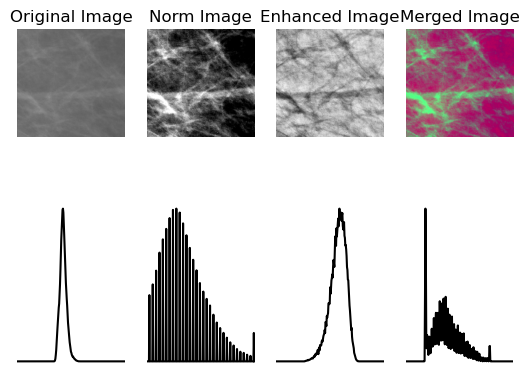

Path: DATABASE - DDSM/Normal/0501/A_0501_1.RIGHT_MLO.jpg, Label: 0, Type: 0


Path: DATABASE - DDSM/Normal/0222/A_0222_1.RIGHT_CC.jpg, Label: 0, Type: 0


Path: DATABASE - DDSM/Normal/0043/A_0043_1.LEFT_CC.jpg, Label: 0, Type: 0


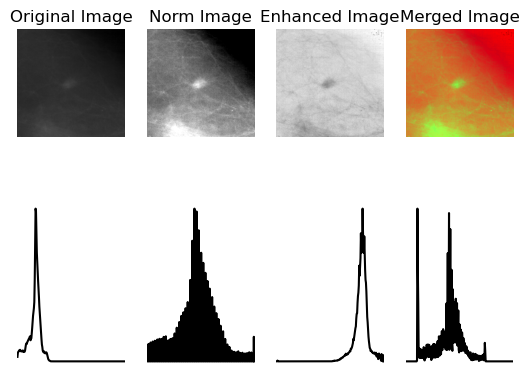

Path: DATABASE - DDSM/Cancer/1848/A_1848_1.RIGHT_MLO.jpg, Label: 2, Type: Indistinct


Path: DATABASE - DDSM/Normal/4516/D_4516_1.RIGHT_CC.jpg, Label: 0, Type: 0


Path: DATABASE - DDSM/Cancer/1871/A_1871_1.RIGHT_MLO.jpg, Label: 2, Type: Indistinct


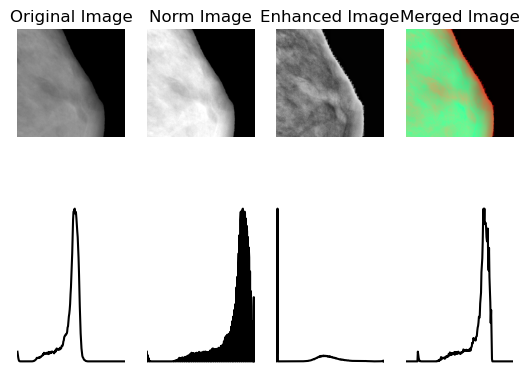

Path: DATABASE - DDSM/Normal/4506/D_4506_1.RIGHT_CC.jpg, Label: 0, Type: 0


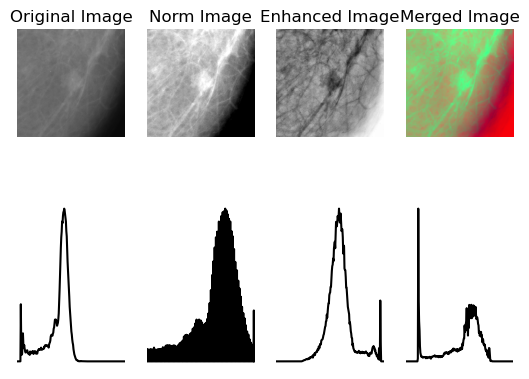

Path: DATABASE - DDSM/Benign/3100/B_3100_1.LEFT_CC.jpg, Label: 1, Type: Lobulated


Path: DATABASE - DDSM/Normal/0219/A_0219_1.RIGHT_MLO.jpg, Label: 0, Type: 0


Path: DATABASE - DDSM/Normal/0264/A_0264_1.RIGHT_MLO.jpg, Label: 0, Type: 0


Path: DATABASE - DDSM/Benign/0386/C_0386_1.LEFT_MLO.jpg, Label: 1, Type: Circumscribed


Path: DATABASE - DDSM/Cancer/0209/C_0209_1.RIGHT_CC.jpg, Label: 2, Type: Lobulated


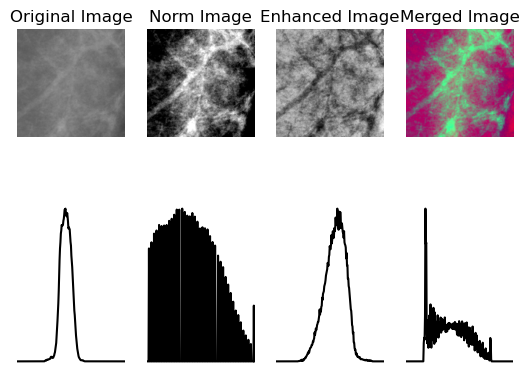

Path: DATABASE - DDSM/Normal/4533/D_4533_1.RIGHT_CC.jpg, Label: 0, Type: 0


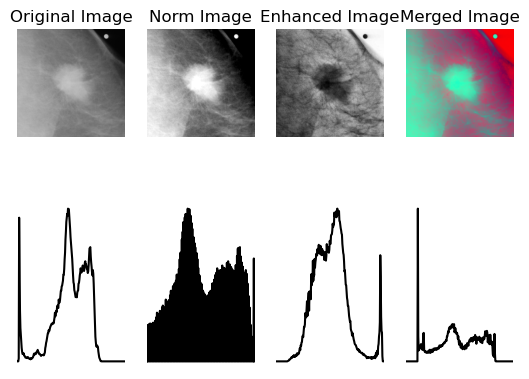

Path: DATABASE - DDSM/Cancer/3064/B_3064_1.LEFT_MLO.jpg, Label: 2, Type: Speculated


Path: DATABASE - DDSM/Normal/0127/A_0127_1.RIGHT_CC.jpg, Label: 0, Type: 0


In [10]:
visualize_images(df_filtered, 'DDSM', num_samples=15, threshold_value = 35, seed=None)

**A partir d'aquest punt el procés és el mateix que en el cas anterior**

## 4.3. Balancegem el dataset

In [11]:
from imblearn.under_sampling import RandomUnderSampler

def balance_dataset(dataset, target_column='Label', random_state=42):
    """
    Realitza un submostreig aleatori per balancejar les classes d'un conjunt de dades.

    Args:
    - dataset (DataFrame): Conjunt de dades a balancejar.
    - target_column (str): Nom de la columna que conté les etiquetes de les classes a balancejar. Per defecte és 'Label'.
    - random_state (int): Valor del seed per a la generació de nombres aleatoris. Per defecte és 42.

    Returns:
    - DataFrame: Conjunt de dades balancejat.
    """

    X = dataset.drop(target_column, axis=1)
    y = dataset[target_column]
    balanced_data, balanced_labels = RandomUnderSampler(random_state=random_state).fit_resample(X, y)
    
    balanced_df = pd.DataFrame(balanced_data, columns=X.columns)
    balanced_df[target_column] = balanced_labels
    
    return balanced_df

df_balanced = balance_dataset(df_filtered)


## 4.4. Dividim el dataset en train-test-val

In [12]:
def split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=121):
    """
    Divideix un DataFrame en conjunts de dades de tren, validació i prova segons les proporcions especificades.
    
    Arguments:
    df: pandas.DataFrame
        El DataFrame que conté les dades.
    train_size: float, opcional (per defecte és 0.7)
        La proporció del conjunt de dades a utilitzar com a conjunt d'entrenament.
    val_size: float, opcional (per defecte és 0.15)
        La proporció del conjunt de dades a utilitzar com a conjunt de validació.
    test_size: float, opcional (per defecte és 0.15)
        La proporció del conjunt de dades a utilitzar com a conjunt de prova.
    random_state: int, opcional (per defecte és 42)
        El valor de la llavor per a la generació de nombres aleatoris.

    Returns:
    tuple
        Una tupla que conté tres DataFrames: (train_df, val_df, test_df).
    """
    df_shuffled = df.sample(frac=1, random_state=random_state)

    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=random_state, stratify=df['Label'])
    val_df, test_df = train_test_split(temp_df, test_size=test_size / (val_size + test_size), random_state=random_state, stratify=temp_df['Label'])

    return train_df, val_df, test_df

train_df, val_df, test_df = split_dataset(df_balanced)


## 4.5. Preprocessem les imatges i creem un array de numpy per cada conjunt d'entrenament, validació i prova

In [13]:
test_images, test_labels= preprocess(test_df, target_size = 224)

In [14]:
val_images, val_labels = preprocess(val_df, target_size = 224)

In [15]:
train_images, train_labels = preprocess(train_df, target_size = 224)

In [16]:
train_df.to_csv('train_patches.csv', index=False) 
val_df.to_csv('val_patches.csv', index=False) 
test_df.to_csv('test_patches.csv', index=False) 

In [17]:
np.save('test_images.npy', test_images)
np.save('test_labels.npy', test_labels)
np.save('val_images.npy', val_images)
np.save('val_labels.npy', val_labels)
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)

## 4.6. Comprovem que els resultats siguin els esperats

In [18]:
plot_examples_post(test_images, test_labels, 64, seed=43)